# Selection of a location for drilling an oil well

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

## Data preparation

In [2]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', index_col='id')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', index_col='id')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', index_col='id')

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


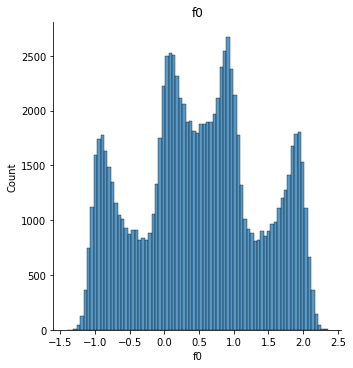

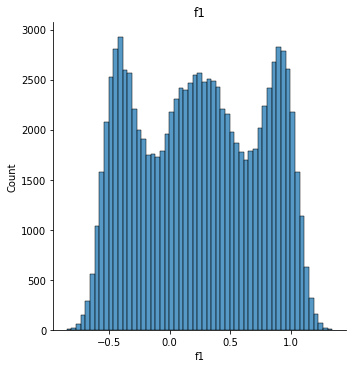

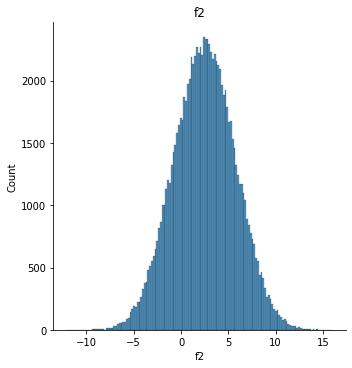

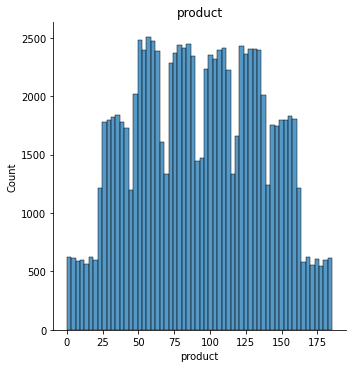

In [4]:
for column in geo_data_0.columns:
    sns.displot(geo_data_0[column])
    plt.title(column)
    plt.show()

In [5]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


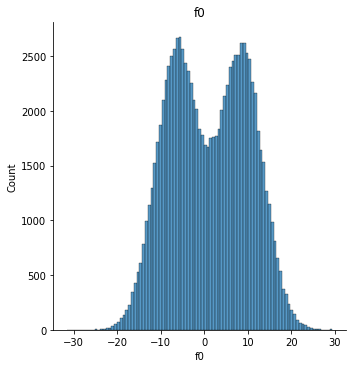

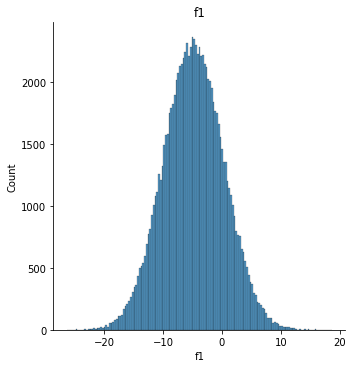

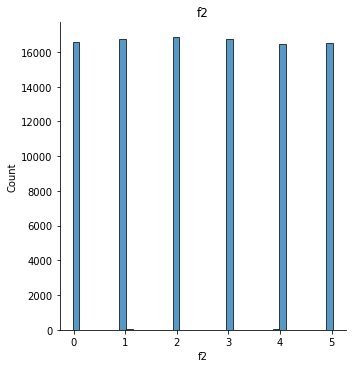

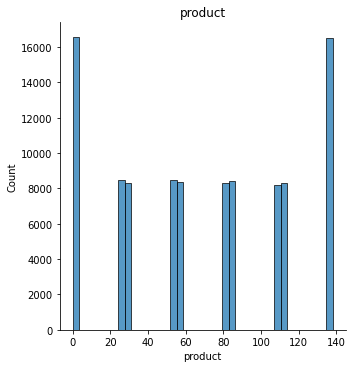

In [6]:
for column in geo_data_1.columns:
    sns.displot(geo_data_1[column])
    plt.title(column)
    plt.show()

In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


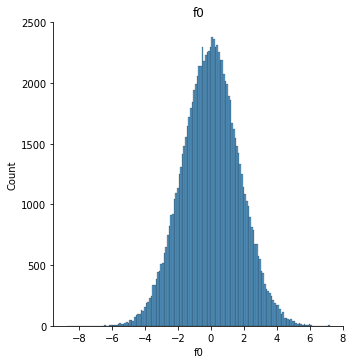

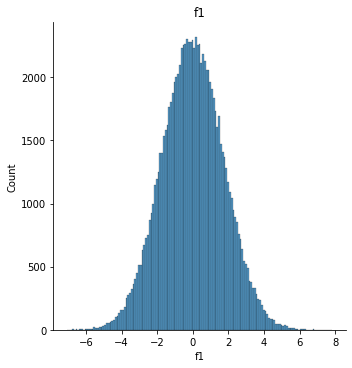

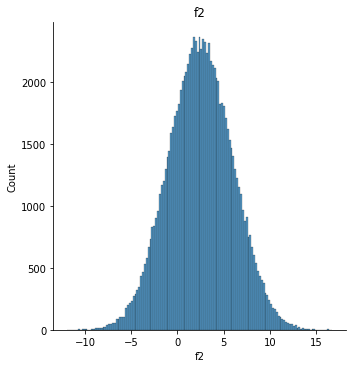

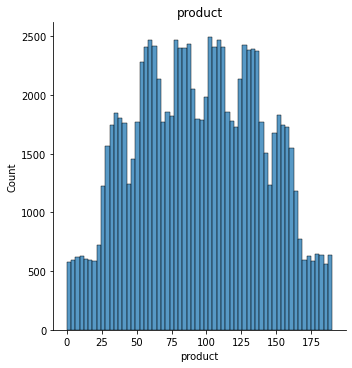

In [8]:
for column in geo_data_2.columns:
    sns.displot(geo_data_2[column])
    plt.title(column)
    plt.show()

In [9]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    display(data.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Я не заметила каких-то аномалий в данных - нет пропущенных значений или выбросов. Единственное, что меня смутило - радикально разная форма распределений для трёх регионов (иногда кажется, что переменные перепутаны местами - например, f1 первого региона похож на f2 нулевого региона) - но за неимением открытых данных примем на веру, что названия признаков не перепутаны.

## Model training and evaluation

### train-test split

In [10]:
geo_data_0_train, geo_data_0_test = train_test_split(geo_data_0, test_size=.25, random_state=42)
geo_data_1_train, geo_data_1_test = train_test_split(geo_data_1, test_size=.25, random_state=42)
geo_data_2_train, geo_data_2_test = train_test_split(geo_data_2, test_size=.25, random_state=42)

### model training

In [11]:
y_preds = []
i = 0

for train, test in zip([geo_data_0_train, geo_data_1_train, geo_data_2_train], 
                      [geo_data_0_test, geo_data_1_test, geo_data_2_test]):
    model = LinearRegression()
    X_train = train.drop('product', axis=1)
    y_train = train['product']
    model.fit(X_train, y_train)

    X_test = test.drop('product', axis=1)
    y_test = test['product']
    y_pred = model.predict(X_test)
    y_preds.append(pd.Series(y_pred, index=X_test.index))

    print(f'средняя предсказанная добыча для региона {i}: {y_pred.mean()}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    
    i+=1

средняя предсказанная добыча для региона 0: 92.39879990657768
RMSE: 37.75660035026169
средняя предсказанная добыча для региона 1: 68.71287803913762
RMSE: 0.890280100102884
средняя предсказанная добыча для региона 2: 94.77102387765939
RMSE: 40.145872311342174


Минимальный rmse - у модели, построенной для региона 1. Максимальная средняя добыча (с бОльшим rmse - у модели, построенной для региона 2).

## Calculation of profits

### Calculation of the sufficient volume of resources for the profitable development of a new well

In [12]:
n_wells = 200
budget = 10**10
profit_per_barrel = 450000
n_wells_init = 500

In [13]:
print(f'''Бюджет на разработку {n_wells} скважин в регионе (по условиям задачи) - {budget} рублей.
Значит, одна скважина должна приносить {budget}/{n_wells} = {budget/n_wells} рублей. Это {budget/n_wells}/{profit_per_barrel} = {budget/n_wells/profit_per_barrel} тыс баррелей. Средние предсказания для всех трёх регионов несколько недотягивают до этой оценки, но ближе всего - средняя предсказанная оценка для регионов 0 и 2. 
Следовательно, если разброс добычи по скважинам в регионе не очень большой (топ-200 скважин по добыче сравнимы со средним), или наша модель недостаточно точно предсказывает самые перспективные скважины, может оказаться, что с тем инструментарием, что у нас есть, мы пока не сможем найти регион, отвечающий всем запросам''')

Бюджет на разработку 200 скважин в регионе (по условиям задачи) - 10000000000 рублей.
Значит, одна скважина должна приносить 10000000000/200 = 50000000.0 рублей. Это 50000000.0/450000 = 111.11111111111111 тыс баррелей. Средние предсказания для всех трёх регионов несколько недотягивают до этой оценки, но ближе всего - средняя предсказанная оценка для регионов 0 и 2. 
Следовательно, если разброс добычи по скважинам в регионе не очень большой (топ-200 скважин по добыче сравнимы со средним), или наша модель недостаточно точно предсказывает самые перспективные скважины, может оказаться, что с тем инструментарием, что у нас есть, мы пока не сможем найти регион, отвечающий всем запросам


## Calculation of profits and risks

У нас нет никаких данных о расходах, кроме бюджета на разработку скважин, поэтому будем считать, что все расходы (налоги, оборудование и тд) составляют 10 млрд руб. Операционную прибыль посчитаем как совокупный доход с 200 самых перспективных скважен.

In [14]:
def profit_calc(predicted_product, observed_product):
    df = pd.DataFrame({'pred': predicted_product, 'obs': observed_product})
    obs = df.sort_values(by='pred', ascending=False).iloc[:n_wells]['obs']
    oper_profit = obs.sum()*profit_per_barrel
    profit = oper_profit - budget 
    return profit

In [15]:
def bootstrap(predicted_product, observed_product, n_wells_init):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        subsample = pd.Series(predicted_product).sample(n_wells_init, replace=True, random_state=state)
        values.append(profit_calc(subsample, observed_product.reindex(subsample.index)))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    loss = np.sum(values < 0)/len(values)*100
    return mean, upper, lower, loss

In [16]:
i=0

for prediction, y_test in zip(y_preds, [geo_data_0_test['product'], geo_data_1_test['product'], 
                                        geo_data_2_test['product']]):
    mean, upper, lower, loss = bootstrap(prediction, y_test, n_wells_init)
    print(f'для региона {i} средняя предсказанная прибыль при разработке {n_wells} скважин составила {mean} рублей с 95%CI от {lower} до {upper}. Риск убытков при разработке этого региона - {loss} %.\n')
    i+=1

для региона 0 средняя предсказанная прибыль при разработке 200 скважин составила 406278783.42441905 рублей с 95%CI от -117742136.49486831 до 911737050.7514055. Риск убытков при разработке этого региона - 6.7 %.

для региона 1 средняя предсказанная прибыль при разработке 200 скважин составила 432624131.8131374 рублей с 95%CI от 16846174.932430126 до 815972526.2857513. Риск убытков при разработке этого региона - 1.9 %.

для региона 2 средняя предсказанная прибыль при разработке 200 скважин составила 377362192.4229165 рублей с 95%CI от -170780417.7057271 до 901772131.3864455. Риск убытков при разработке этого региона - 7.3999999999999995 %.



Вывод: единственный регион с риском убытков < 2.5% при разработке 200 скважин - регион 1. Это довольно неожиданный результат, учитывая, что в этом регионе самая низкая средная добыча. Возможно, дело в том, что соответствующая модель имеет минимальный rmse, с большим отрывом от других моделей, и это похволяет надёжно выбрать лучшие места для разработки. 